## Second Model: Logistic Regression

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [3]:
#Load in the dataset
diabetes_df = pd.read_csv('cleaned_diabetes_data.csv', index_col=0)

In [4]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,Otherwise
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,No,Yes,Otherwise
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,Steady,No,No,No,No,No,No,Yes,Otherwise
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise


## Preprocessing and Encoding the Data

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# train test split
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# model validation: testing model variance with cross validation
from sklearn.model_selection import KFold, cross_val_score, cross_validate, ShuffleSplit

#Feature Selection
X = diabetes_df.drop(['readmitted'], axis=1)
y= diabetes_df['readmitted']

#Label encode target variable 'y' into numerics
labenc = LabelEncoder()
y = labenc.fit_transform(y)



In [7]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, random_state = 42)

In [8]:
X_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

Using the same helper functoins to encode out train and testing data

In [9]:
def encode_and_concat_feature(X, feature_name, ohe):
  
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    
    #create unique column names by prefixing with feature name
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns=ohe_column_names, index=X.index)

    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [10]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

Apply the functions to the train and test data

In [11]:
categorical_feature_names = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id','payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3','max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide','citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

encoders = {}

#Encode X_train and store encoders
for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [20]:
encoders

{'race': OneHotEncoder(handle_unknown='ignore'),
 'gender': OneHotEncoder(handle_unknown='ignore'),
 'age': OneHotEncoder(handle_unknown='ignore'),
 'admission_type_id': OneHotEncoder(handle_unknown='ignore'),
 'discharge_disposition_id': OneHotEncoder(handle_unknown='ignore'),
 'admission_source_id': OneHotEncoder(handle_unknown='ignore'),
 'payer_code': OneHotEncoder(handle_unknown='ignore'),
 'medical_specialty': OneHotEncoder(handle_unknown='ignore'),
 'diag_1': OneHotEncoder(handle_unknown='ignore'),
 'diag_2': OneHotEncoder(handle_unknown='ignore'),
 'diag_3': OneHotEncoder(handle_unknown='ignore'),
 'max_glu_serum': OneHotEncoder(handle_unknown='ignore'),
 'A1Cresult': OneHotEncoder(handle_unknown='ignore'),
 'metformin': OneHotEncoder(handle_unknown='ignore'),
 'repaglinide': OneHotEncoder(handle_unknown='ignore'),
 'nateglinide': OneHotEncoder(handle_unknown='ignore'),
 'chlorpropamide': OneHotEncoder(handle_unknown='ignore'),
 'glimepiride': OneHotEncoder(handle_unknown='igno

In [21]:
def encode_and_concat_feature_test(X_test, feature_name, ohe):
    """
    Helper function for transforming test data. It takes in the full X_test dataframe,
    the feature name, and the already fitted encoder from X_train. Returns the transformed
    X_test with that feature encoded into multiple columns of 1s and 0s.
    """
    #Create new one-hot encoded df for the feature using the fitted encoder from X_train
    single_feature_df = X_test[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()

    #Ensure column names have same prefix structure as in X train
    ohe_column_names = [f'{feature_name}_{category}' for category in ohe.categories_[0]]
    ohe_df = pd.DataFrame(feature_array, columns = ohe_column_names, index=X_test.index)

    #Drop the old feature from X_test and concat the new one-hot encoded df
    X_test = X_test.drop(feature_name, axis=1)
    X_test = pd.concat([X_test, ohe_df], axis=1)
    
    return X_test

# Encode X_test using the fitted encoders
for categorical_feature in categorical_feature_names:
    X_test = encode_and_concat_feature_test(X_test, categorical_feature, encoders[categorical_feature])


In [22]:
# Check encoding
X_train

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
29262,1,36,1,24,0,0,1,4,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
54052,8,49,0,10,1,0,0,5,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
93790,3,4,0,20,2,0,1,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
66811,2,53,0,12,0,0,0,6,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
6103,5,44,4,49,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49643,1,3,0,7,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
7670,9,48,6,33,0,0,0,8,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
77026,6,29,1,14,0,0,0,4,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
921,7,69,1,23,0,0,0,9,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [23]:
X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
80578,6,60,2,21,1,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
60241,2,32,4,13,0,0,0,9,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
68768,2,20,0,12,0,0,0,5,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
47021,4,35,0,21,0,0,0,5,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
80121,4,67,0,12,1,0,0,7,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6829,7,42,3,20,0,0,0,6,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
46177,6,18,2,16,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
16916,2,40,2,10,0,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
64743,3,9,0,18,42,0,0,9,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [29]:
X_train.shape

(52479, 2312)

In [27]:
y_train.shape

(52479,)

In [30]:
X_test.shape

(17494, 2312)

In [28]:
y_test.shape

(17494,)

## Cross Validation

We need to scale the features before regularization

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)



## Build the model

In [54]:
# initialize the logistic regression

model = LogisticRegression(penalty='l2', class_weight='balanced', solver='lbfgs', max_iter=1000)

# fit the scaled training data to the model
#
model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [34]:
model.score(X_train_scaled,y_train)

0.6732978905848054

## Apply cross validation to the model

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=3)
cross_val_score(model, X_train_scaled, y_train, cv=skf, n_jobs=-1)


array([0.64911679, 0.63819814, 0.65609101])

## Initial Model Evaluation

In [38]:
# Feature weights
model.coef_

array([[-0.01369348, -0.00775064,  0.00718441, ..., -0.00919901,
         0.06775443, -0.06775443]])

In [39]:
model.intercept_

array([0.89555953])

In [40]:
y_pred = model.predict(X_test_scaled)
y_pred

array([0, 1, 0, ..., 1, 0, 1])

In [57]:
#test accuracy score
model.score(X_test_scaled,y_test)

0.6528524065393849

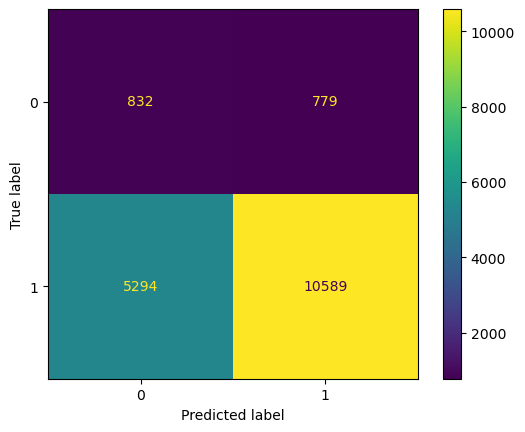

In [58]:
cfmat = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, display_labels={0: '<30', 1:'Otherwise'})

plt.savefig('Second_Model_CFMAT.png')

In [60]:
from sklearn.metrics import precision_score

precision = precision_score(y_test,y_pred)
precision

0.9314743138634765

In [56]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
recall

0.6666876534659699

In [24]:
accuracy_score(y_test, y_pred)

0.6607408254258603

In [52]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.14      0.52      0.22      1611
           1       0.93      0.67      0.78     15883

    accuracy                           0.65     17494
   macro avg       0.53      0.59      0.50     17494
weighted avg       0.86      0.65      0.73     17494



In [37]:
#Class probabilities
model.predict_proba(X_test_scaled)

array([[0.58659082, 0.41340918],
       [0.3120556 , 0.6879444 ],
       [0.5397226 , 0.4602774 ],
       ...,
       [0.48708435, 0.51291565],
       [0.77018986, 0.22981014],
       [0.48729597, 0.51270403]])

# Official Evaluation of Second Model:

This model performed a lot worse than I expected it to. The performance scores were about the same as the decision tree, if not worse. It did not handle high dimensionality as well as I thought it would. It is still overfitting to the majority class and is worse at predicting the minority class.

Compared to the baseline model, it is worse at predicting true negatives and turns out about the same amount of false negatives. This is counterintuitive to our business question because we want high accuracy for both true negative and true positive, but especially for the true negatives, which are the patients most likely to be readmitted within 30 days of discharge. 

# Next Steps

For my next step, I want to go back to using a Decision Tree Classifier because I think it is better at handling a lot of features with complex non-linear relationships. I plan to do some major feature reduction and see if my results improve. If I don't see much of an improvement, then that will signal that the bigger issue is bias on the majority class. 